In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


import statsmodels.formula.api as sm, statsmodels.stats.api as sms


from run_id import run_id

run_id = 654

runstat = RunStats.objects.get(pk=run_id)

In [2]:
if runstat.method=="DT":
    ts = DynamicTopic.objects.filter(run_id=run_id)
else:
    ts = Topic.objects.filter(
        run_id=run_id,
        topicarscores__ar=5,
        topicarscores__share__gt=0.005
    )

df = pd.DataFrame.from_dict(
        list(ts.order_by('-ipcc_coverage').values('title','ipcc_coverage'))
)

df.head()

,ipcc_coverage,title
0,0.316301,"{aerosol, cloud, radiat}"
1,0.291992,"{adapt, vulner, capac}"
2,0.268221,"{scenario, futur, uncertainti}"
3,0.262386,"{ozon, stratospher, tropospher}"
4,0.247353,"{simul, model, observ}"


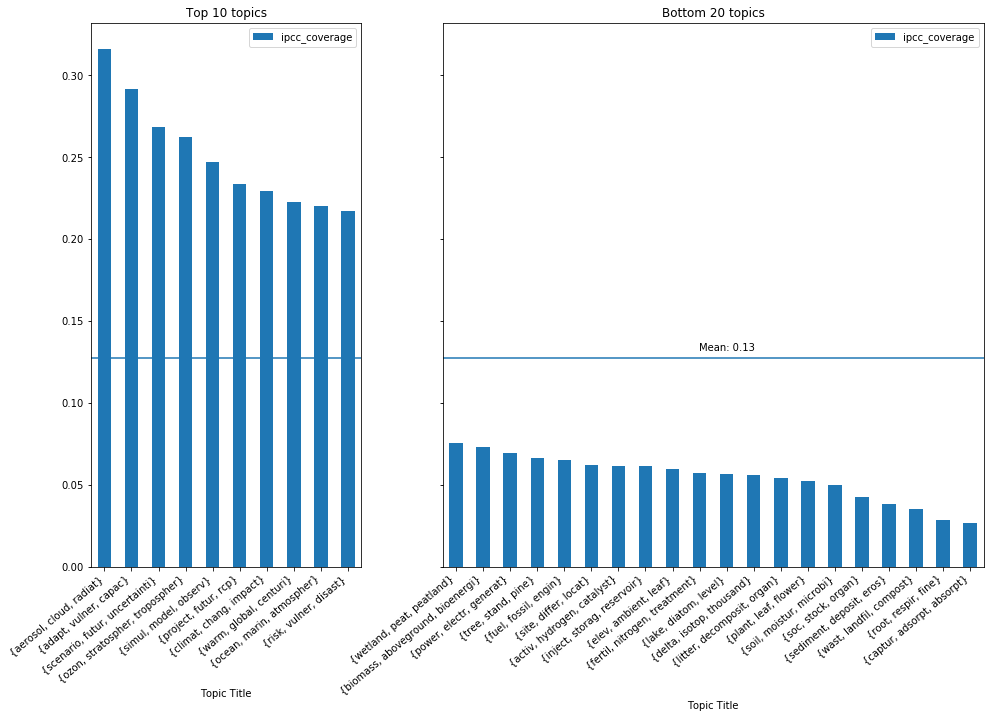

In [3]:
plt.rcParams["figure.figsize"] = [16,10]

# plot it
fig = plt.figure(figsize=(16, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharey=ax0)

axs = [ax0,ax1]

nn = 15


i=0
for ax in axs:

    bdf = df.set_index(['title'])[['ipcc_coverage']]

    m = bdf['ipcc_coverage'].mean()
    
    #ax.set_ylim([0, 20])
    
    if i==0:
        n = nn-5
        bdf.head(n).plot.bar(ax=ax)
        ax.set_title('Top {} topics'.format(n))
    else:
        n = nn+5
        bdf.tail(n).plot.bar(ax=ax)
        ax.set_title('Bottom {} topics'.format(n))
        ax.text(n/2,m*1.05,"Mean: {}".format(round(m,2)),ha="center",va="center")
    ax.axhline(y=m)
        
    i+=1
    
    ax.set_xlabel('Topic Title')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
plt.xlabel('Topic Title')

plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [4]:
df = pd.DataFrame.from_dict(
        list(ts.order_by('-ipcc_coverage').values('title','ipcc_coverage','primary_wg','wg_1','wg_2','wg_3'))
)

df.head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3
0,0.316301,1,"{aerosol, cloud, radiat}",0.920251,0.046648,0.033101
1,0.291992,2,"{adapt, vulner, capac}",0.002592,0.860198,0.137210
2,0.268221,2,"{scenario, futur, uncertainti}",0.226164,0.651714,0.122121
3,0.262386,1,"{ozon, stratospher, tropospher}",0.762022,0.210545,0.027433
4,0.247353,1,"{simul, model, observ}",0.756024,0.229094,0.014882


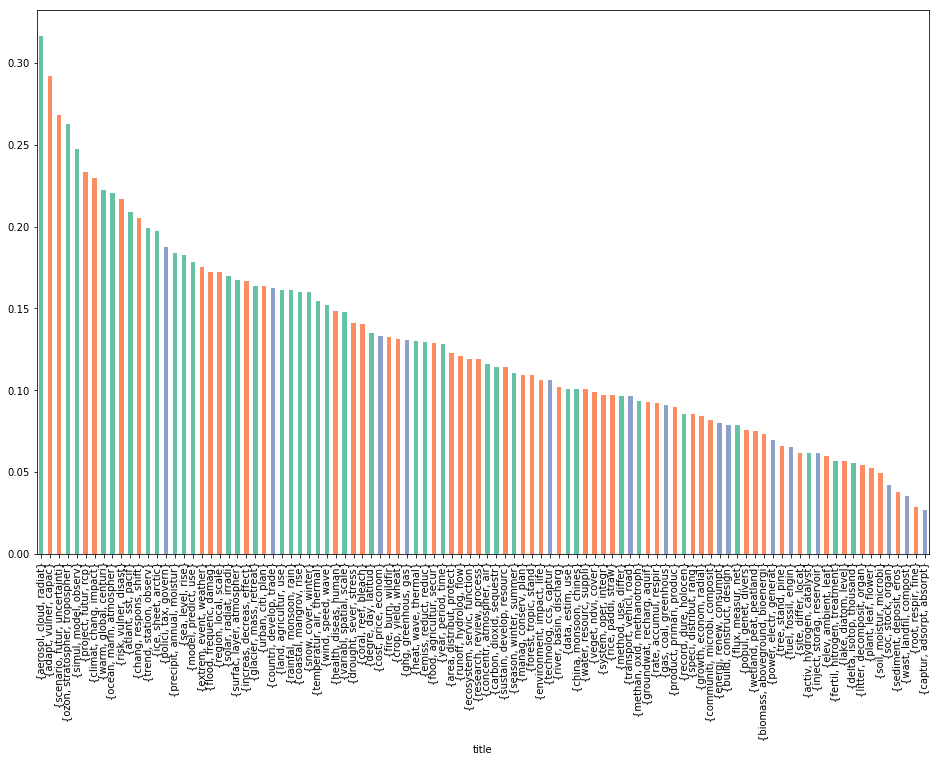

In [5]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

bdf = df.set_index(['title'])

bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

plt.show()

In [29]:
soil_tops = Topic.objects.filter(
    topicterm__run_id=run_id,
    topicterm__term__title="soil"
)
print(soil_tops.count())

soil_tops

41


<QuerySet [<Topic: {emiss, soil, fertil}>, <Topic: {concentr, mol, air}>, <Topic: {plant, yield, growth}>, <Topic: {forest, ecosystem, soil}>, <Topic: {degre, month, precipit}>, <Topic: {carbon, sediment, cycl}>, <Topic: {methan, sourc, gas}>, <Topic: {soil, organ, moistur}>, <Topic: {crop, yield, agricultur}>, <Topic: {forest, manag, boreal}>, <Topic: {veget, pollen, map}>, <Topic: {rice, paddi, field}>, <Topic: {soil, moistur, organ}>, <Topic: {forest, tropic, boreal}>, <Topic: {methan, landfil, wetland}>, <Topic: {root, fine, respir}>, <Topic: {ecosystem, tundra, net}>, <Topic: {rice, paddi, field}>, <Topic: {land, agricultur, use}>, <Topic: {veget, type, pollen}>, '...(remaining elements truncated)...']>

In [6]:
mixtures = ts.order_by('-ipcc_coverage').values('title','primary_wg','wg_1','wg_2','wg_3','ipcc_coverage')

df = pd.DataFrame.from_dict(list(mixtures))
df['WG 1'] = df['ipcc_coverage'] * df['wg_1']
df['WG 2'] = df['ipcc_coverage'] * df['wg_2']
df['WG 3'] = df['ipcc_coverage'] * df['wg_3']


df.head(20)

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3
0,0.316301,1,"{aerosol, cloud, radiat}",0.920251,0.046648,0.033101,0.291076,0.014755,0.010470
1,0.291992,2,"{adapt, vulner, capac}",0.002592,0.860198,0.137210,0.000757,0.251171,0.040064
2,0.268221,2,"{scenario, futur, uncertainti}",0.226164,0.651714,0.122121,0.060662,0.174804,0.032756
3,0.262386,1,"{ozon, stratospher, tropospher}",0.762022,0.210545,0.027433,0.199944,0.055244,0.007198
4,0.247353,1,"{simul, model, observ}",0.756024,0.229094,0.014882,0.187005,0.056667,0.003681
5,0.233486,2,"{project, futur, rcp}",0.156437,0.503239,0.340324,0.036526,0.117499,0.079461
6,0.229406,2,"{climat, chang, impact}",0.375187,0.582814,0.041999,0.086070,0.133701,0.009635
7,0.222424,1,"{warm, global, centuri}",0.628925,0.303175,0.067900,0.139888,0.067434,0.015103
8,0.220348,1,"{ocean, marin, atmospher}",0.765757,0.210553,0.023690,0.168733,0.046395,0.005220
9,0.217124,2,"{risk, vulner, disast}",0.021755,0.836658,0.141587,0.004723,0.181659,0.030742


## For each topic, what percentage of documents are cited by IPCC, and in what working groups are they?

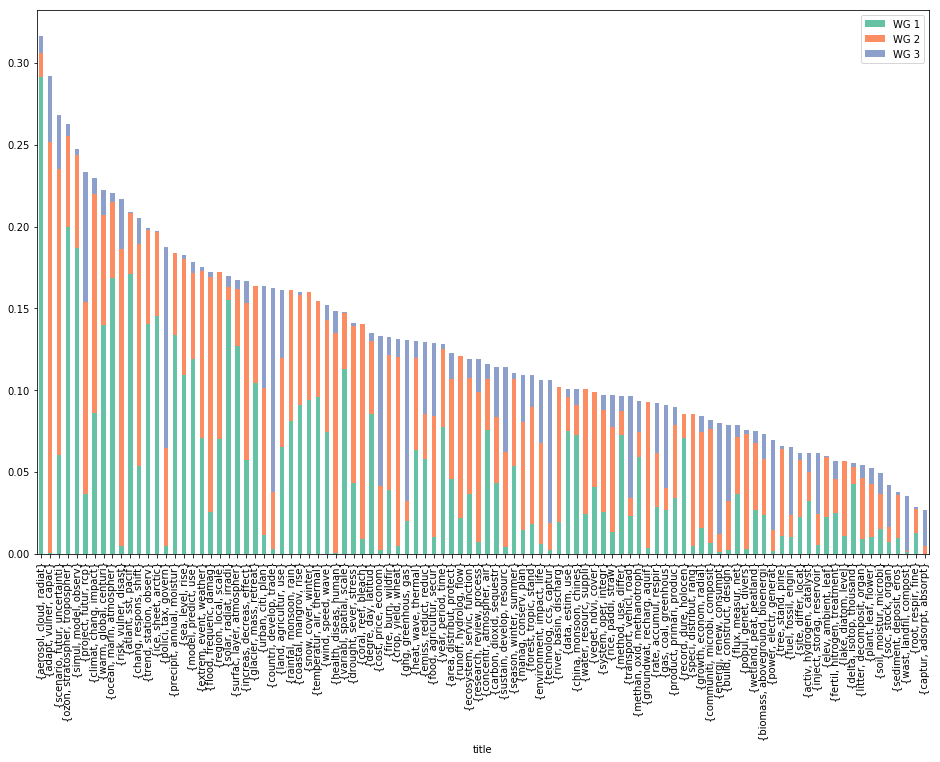

In [7]:
plt.rcParams["figure.figsize"] = [16,10]

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

colors = ["#66c2a5","#fc8d62","#8da0cb"]

bdf = df.set_index(['title'])

#bdf['ipcc_coverage'].plot(kind='bar', color=[colors[i] for i in bdf['primary_wg']])

bdf[['WG 1','WG 2','WG 3']].plot(kind='bar', stacked=True, color = colors)

plt.savefig('../plots/ipcc_topics_wg_{}.png'.format(run_id),bbox_inches='tight')   


plt.show()

The topics dealing with issues frequently cited by working group 1 are more 

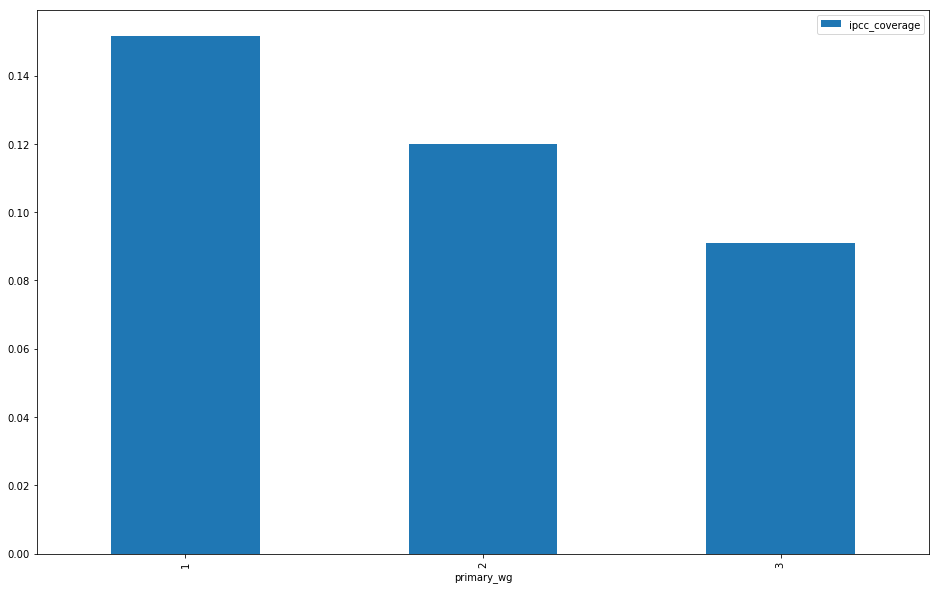

In [8]:
df[['ipcc_coverage','primary_wg']].groupby('primary_wg').mean().plot.bar()
plt.savefig('../plots/ipcc_coverage_by_wg_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [9]:
df['wg1_3'] = df['wg_1'] * df['wg_3']
df['wg1_2'] = df['wg_1'] * df['wg_2']
df['wg2_3'] = df['wg_2'] * df['wg_3']

df.sort_values('wg1_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
70,0.091147,3,"{gas, coal, greenhous}",0.295369,0.147394,0.557237,0.026922,0.013435,0.050790,0.164591,0.043536,0.082133
66,0.096319,3,"{transport, vehicl, road}",0.238077,0.118207,0.643716,0.022931,0.011386,0.062002,0.153254,0.028142,0.076092
43,0.129442,1,"{emiss, reduct, reduc}",0.449268,0.210199,0.340534,0.058154,0.027208,0.044079,0.152991,0.094435,0.071580
67,0.093262,1,"{methan, oxid, methanotroph}",0.633262,0.163044,0.203694,0.059059,0.015206,0.018997,0.128992,0.103250,0.033211
41,0.130893,3,"{ghg, greenhous, gas}",0.153882,0.093927,0.752191,0.020142,0.012294,0.098457,0.115749,0.014454,0.070651


In [10]:
df.sort_values('wg1_2',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
28,0.161330,1,"{rainfal, monsoon, rain}",0.503239,0.496761,0.000000,0.081188,0.080142,0.000000,0.000000,0.249990,0.000000
62,0.099017,2,"{veget, ndvi, cover}",0.412560,0.587440,0.000000,0.040850,0.058167,0.000000,0.000000,0.242354,0.000000
30,0.160145,1,"{snow, cover, winter}",0.586798,0.411984,0.001218,0.093973,0.065977,0.000195,0.000715,0.241751,0.000502
20,0.172036,2,"{region, local, scale}",0.408166,0.591834,0.000000,0.070219,0.101817,0.000000,0.000000,0.241566,0.000000
29,0.160159,1,"{coastal, mangrov, rise}",0.568398,0.417768,0.013835,0.091034,0.066909,0.002216,0.007864,0.237458,0.005780


In [11]:
df.sort_values('wg2_3',ascending=False).head()

,ipcc_coverage,primary_wg,title,wg_1,wg_2,wg_3,WG 1,WG 2,WG 3,wg1_3,wg1_2,wg2_3
52,0.114099,2,"{sustain, develop, resourc}",0.037581,0.506382,0.456038,0.004288,0.057778,0.052033,0.017138,0.019030,0.230929
77,0.078653,3,"{build, construct, design}",0.028845,0.382123,0.589031,0.002269,0.030055,0.046329,0.016991,0.011023,0.225083
56,0.106353,2,"{environment, impact, life}",0.056292,0.582955,0.360753,0.005987,0.061999,0.038367,0.020308,0.032816,0.210303
14,0.187638,3,"{polici, tax, govern}",0.024842,0.318510,0.656648,0.004661,0.059765,0.123212,0.016312,0.007912,0.209149
25,0.163681,2,"{urban, citi, plan}",0.071674,0.547146,0.381180,0.011732,0.089557,0.062392,0.027321,0.039216,0.208561


In [23]:
'wg_231' in df.columns

False

In [12]:
pd.options.display.float_format = '{:.2f}%'.format

tabdf = df[['ipcc_coverage','primary_wg','title','wg_1','wg_2','wg_3','wg1_2','wg1_3','wg2_3']]

tabdf = tabdf.rename(columns={
    'ipcc_coverage':'IPCC Coverage','primary_wg':'Primary WG','title':'Topic Title',
    'wg_1':'WG 1','wg_2': 'WG 2','wg_3': 'WG 3'
})

cformat = 'p{1.4cm} p{1cm} l r r r'

tabdf = tabdf.sort_values('wg1_2',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_2.tex'.format(run_id),column_format=cformat,index=False)

tabdf = tabdf.sort_values('wg1_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_1_3.tex'.format(run_id),column_format=cformat,index=False)

tabdf = tabdf.sort_values('wg2_3',ascending=False)
ttabdf = tabdf[['IPCC Coverage','Primary WG','Topic Title','WG 1','WG 2','WG 3']]
ttabdf.head().to_latex('../tables/{}_wg_2_3.tex'.format(run_id),column_format=cformat,index=False)



ttabdf.head()


,IPCC Coverage,Primary WG,Topic Title,WG 1,WG 2,WG 3
52,0.11%,2,"{sustain, develop, resourc}",0.04%,0.51%,0.46%
77,0.08%,3,"{build, construct, design}",0.03%,0.38%,0.59%
56,0.11%,2,"{environment, impact, life}",0.06%,0.58%,0.36%
14,0.19%,3,"{polici, tax, govern}",0.02%,0.32%,0.66%
25,0.16%,2,"{urban, citi, plan}",0.07%,0.55%,0.38%


In [15]:
ipccdocs = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('topic__title','doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    score=Sum('score'),
    count=Count('doc',distinct=True)
)
ipdf_tops =  pd.DataFrame.from_dict(list(ipccdocs)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
#ipdf.head()

In [16]:
wgtcounts = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    wgt_score=Sum('score'),
    wgt_count=Count('doc',distinct=True)
)
wgtc =  pd.DataFrame.from_dict(list(wgtcounts)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
wgtc.head()

,AR,WG,wgt_count,wgt_score
0,2.00%,1.00%,249,88.74%
1,2.00%,2.00%,132,47.56%
2,2.00%,3.00%,28,8.99%
3,3.00%,1.00%,733,225.84%
4,3.00%,2.00%,798,239.71%


In [17]:
wgcounts = IPCCRef.objects.all().values('ar','wg__wg').annotate(
    wg_count=Count('pk',distinct=True)
)
wgc =  pd.DataFrame.from_dict(list(wgcounts)).rename(columns={'ar':'AR','wg__wg':'WG'})
wgc.head(15)

,AR,WG,wg_count
0,1.00%,1.00%,901
1,1.00%,2.00%,724
2,1.00%,3.00%,62
3,2.00%,1.00%,2010
4,2.00%,2.00%,2844
5,2.00%,3.00%,1731
6,3.00%,1.00%,4635
7,3.00%,2.00%,6554
8,3.00%,3.00%,2863
9,4.00%,1.00%,5883


In [18]:
ipdf = ipdf_tops.merge(wgc).merge(wgtc)
ipdf.head()

,count,AR,WG,score,topic__title,wg_count,wgt_count,wgt_score
0,407,5.00%,1.00%,2.83%,"{activ, human, enzym}",9524,3829,682.96%
1,120,5.00%,1.00%,0.66%,"{adapt, vulner, capac}",9524,3829,682.96%
2,48,5.00%,1.00%,0.30%,"{adapt, vulner, risk}",9524,3829,682.96%
3,1150,5.00%,1.00%,21.63%,"{aerosol, cloud, radiat}",9524,3829,682.96%
4,369,5.00%,1.00%,10.34%,"{aerosol, forc, radiat}",9524,3829,682.96%


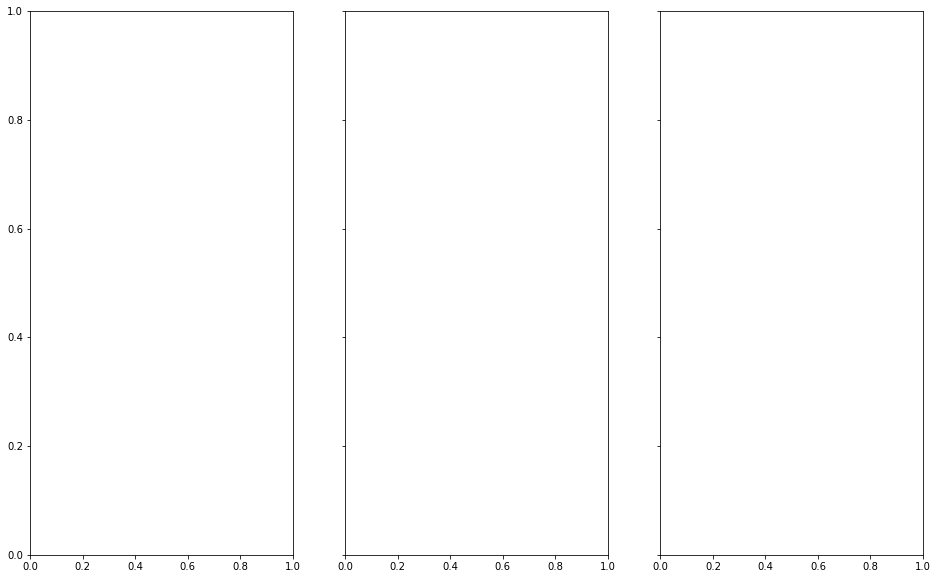

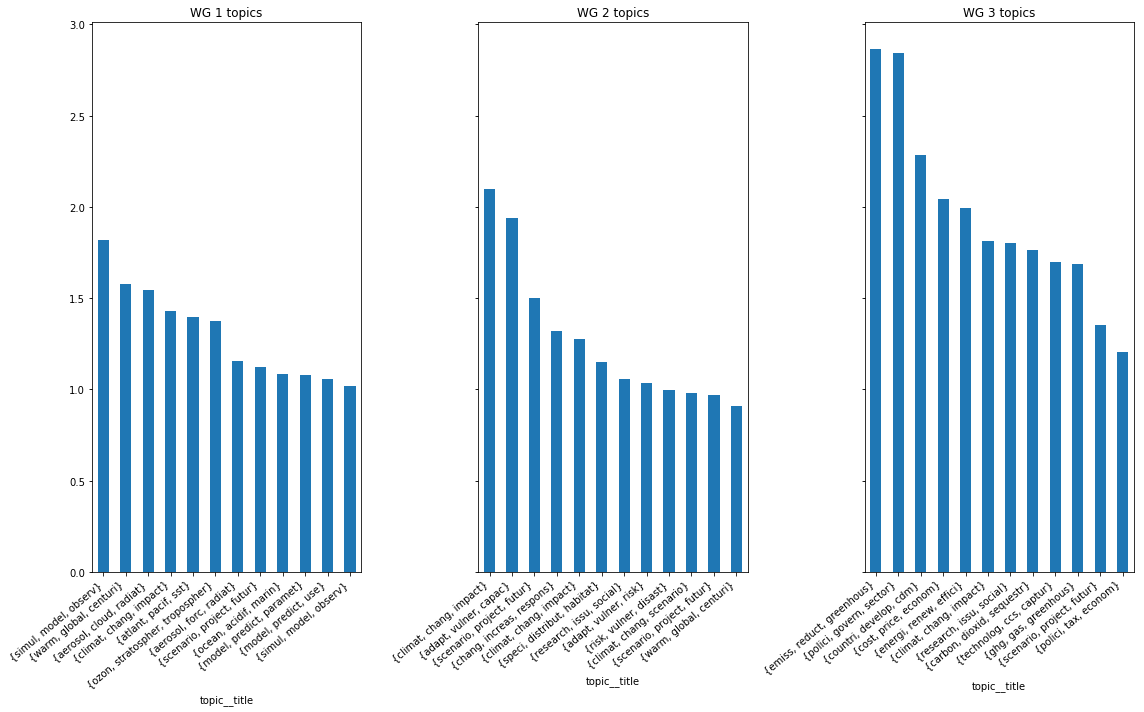

In [19]:
plt.rcParams["figure.figsize"] = [16,10]

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True
)

grouped = ipdf.groupby('WG')

targets = zip(grouped.groups.keys(), axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('WG {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

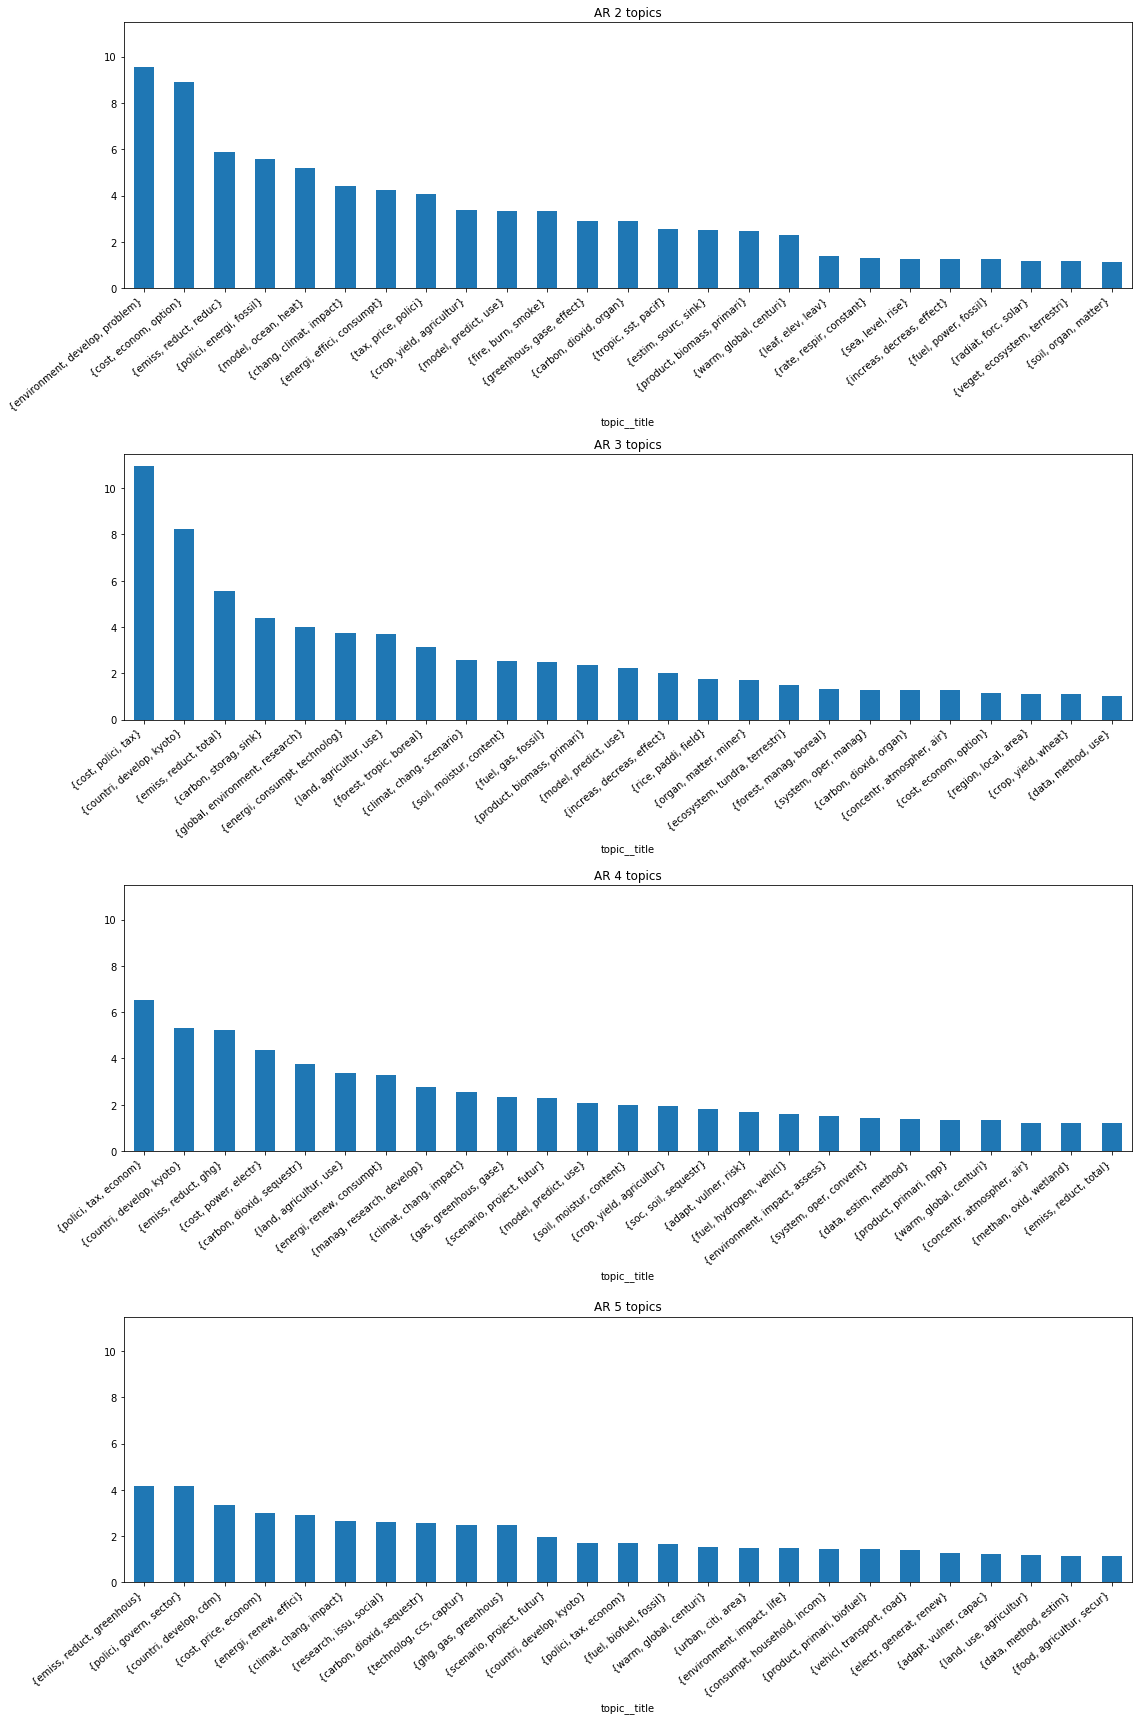

In [20]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=1,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf[ipdf['WG']==3].groupby('AR')

targets = zip(range(2,6), axs.flatten())

n = 25

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

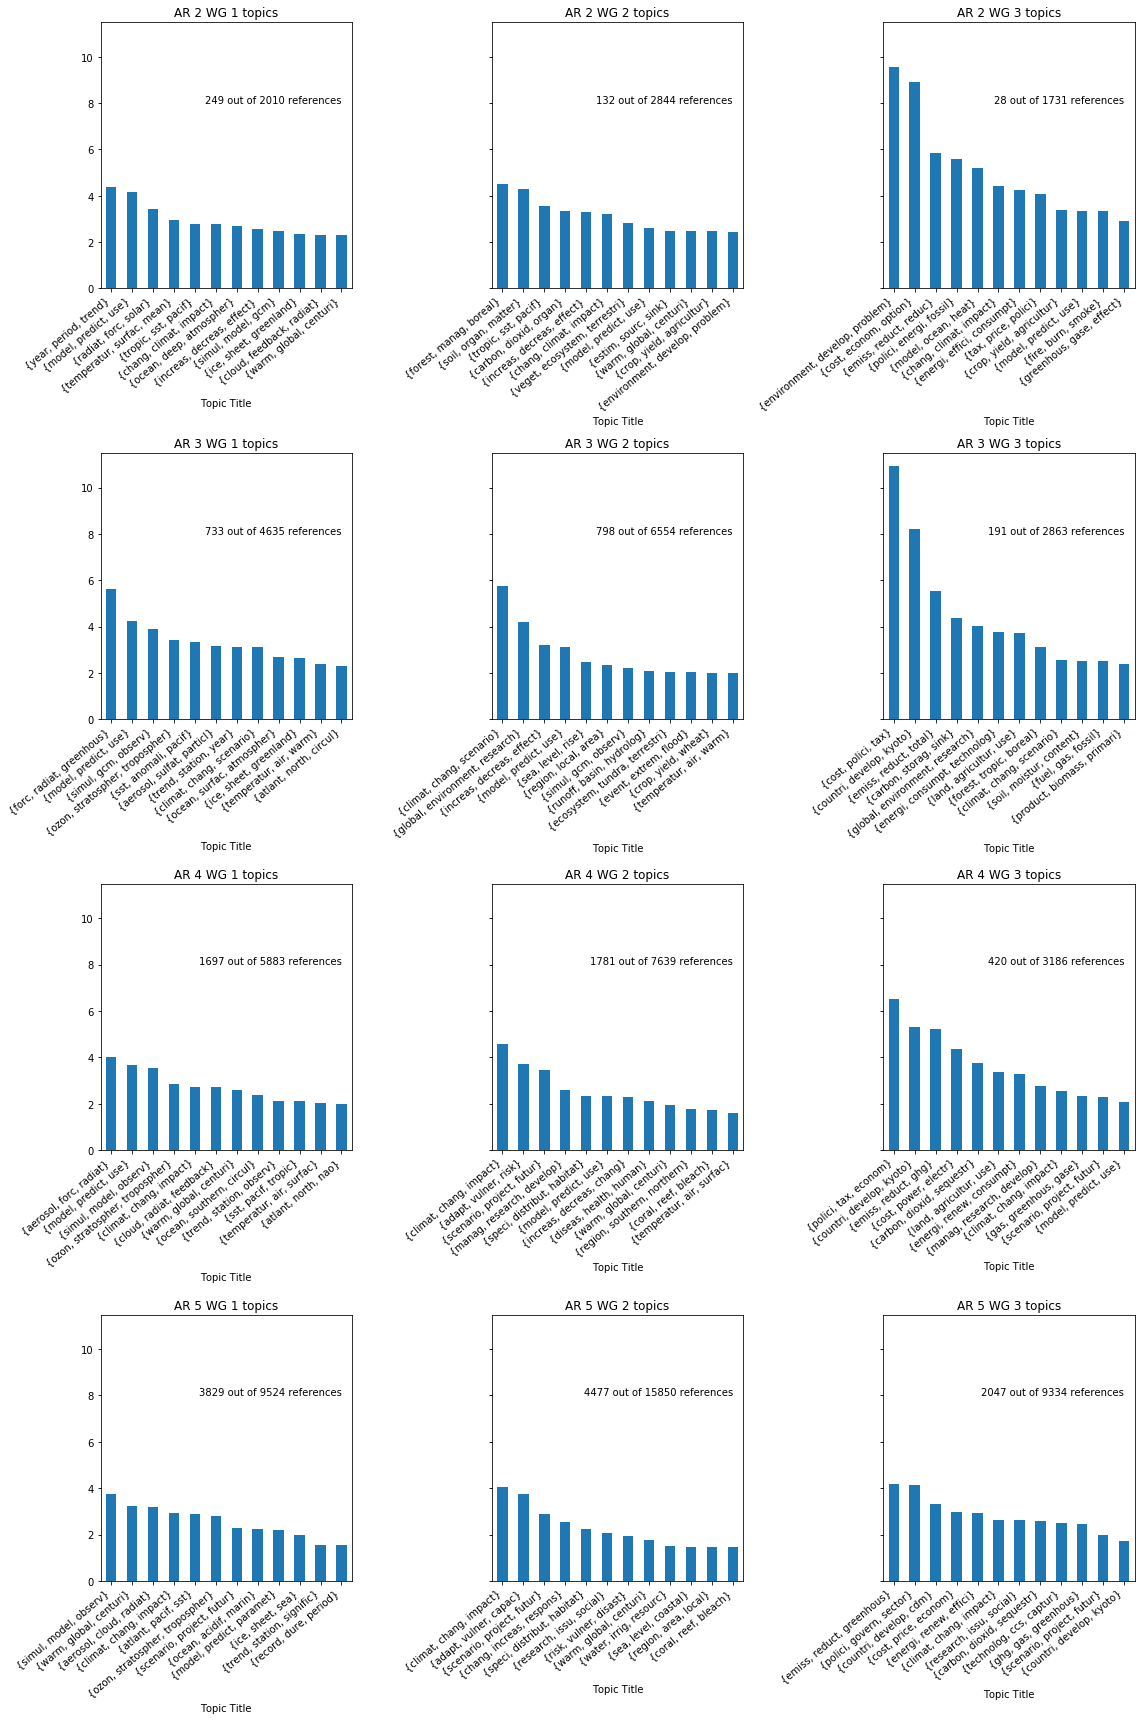

In [21]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf.dropna().sort_values(['AR','WG']).groupby(['AR','WG'])

arorder = []
for x in range(2,6):
    for y in range(1,4):
        arorder.append((float(x),float(y)))

targets = zip(arorder, axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} WG {:.0f} topics'.format(key[0],key[1]))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xlabel('Topic Title')
    text = "{} out of {} references".format(group['wgt_count'][0],group['wg_count'][0])
    ax.text(n-1,8,text,ha="right")

plt.tight_layout()

plt.savefig('../plots/ipcc_topics_ars_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

plt.show()

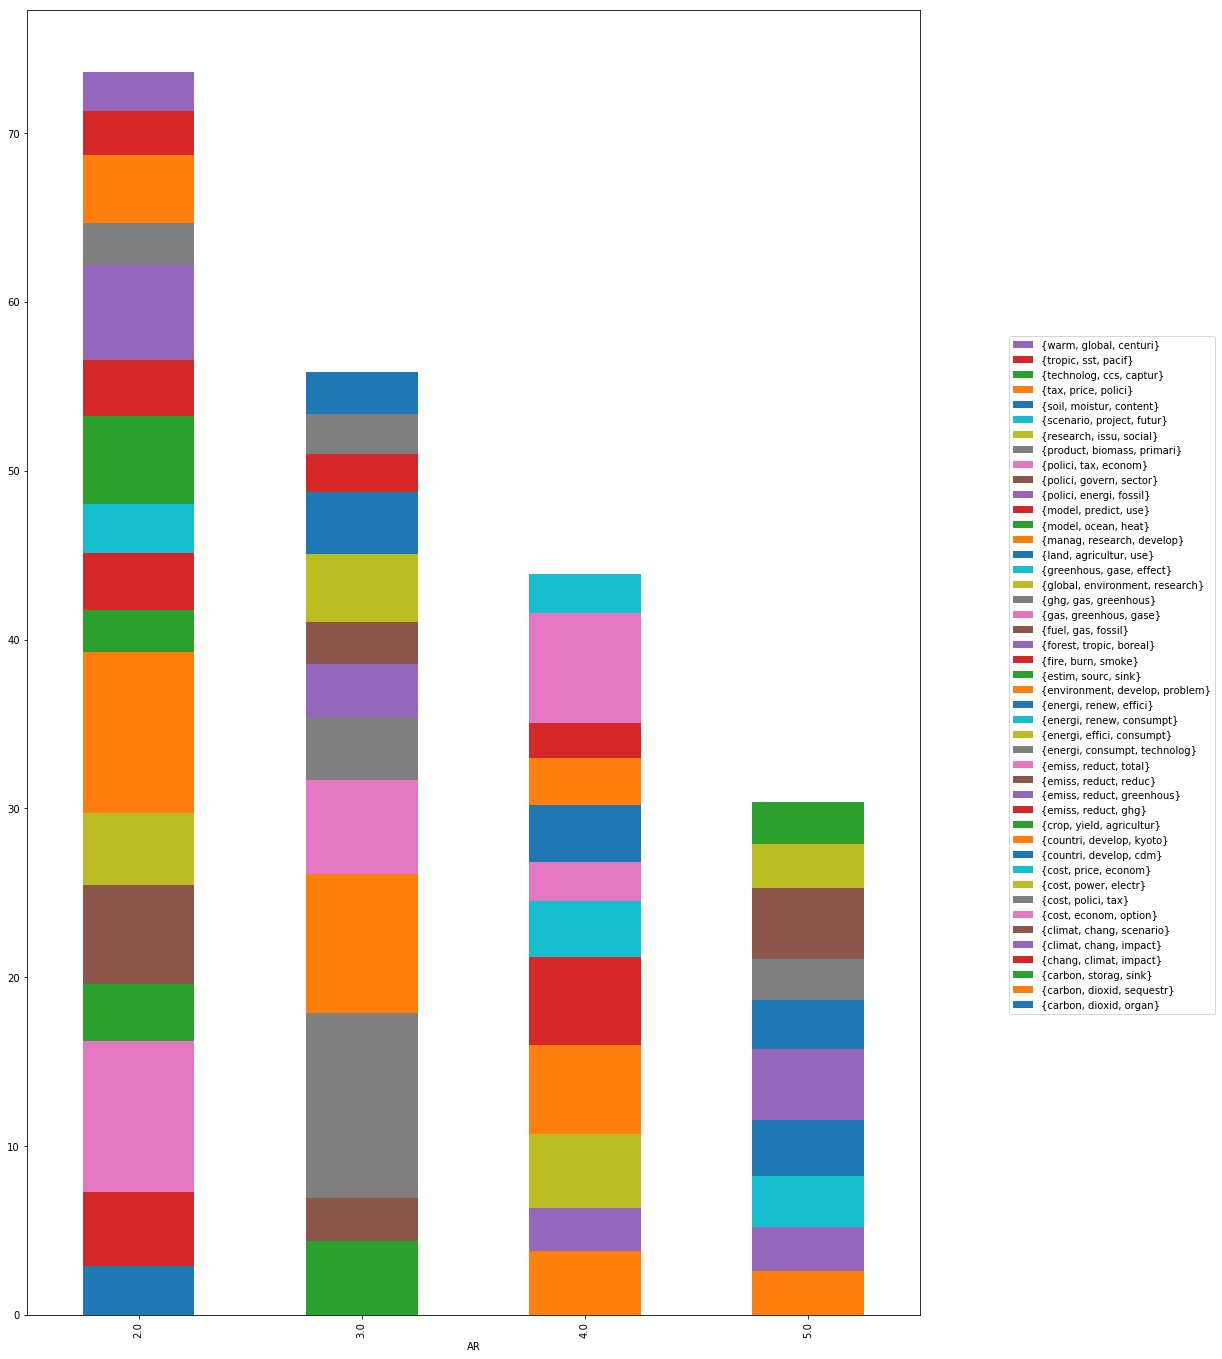

In [22]:
wg3 = ipdf[ipdf['WG']==3].dropna().sort_values(['AR','WG'])

wg3['share'] = wg3['score'] / wg3['wgt_score']*100

wg3 = wg3[wg3['share']>2]

wg3 = wg3[wg3['AR']>1]

wg3 = pd.pivot_table(
                wg3,
                values='share',
                index='AR',
                columns='topic__title'
            )
wg3.head()

fig, ax = plt.subplots()

#ax = enumerate(axs)[0]

wg3.plot.bar(stacked=True,ax=ax)

handles, labels = ax.get_legend_handles_labels()

lpos = (1.1,0.75)

ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)

plt.show()

In [23]:
wgs = [
    {"WG":1, "score": 0},
    {"WG":2, "score": 0},
    {"WG":3, "score": 0}
]
for topic in Topic.objects.filter(run_id=run_id):
    tdocs = Doc.objects.filter(doctopic__topic=topic,doctopic__score__gt=runstat.dthreshold)
    for wg in wgs:
        wgdocs = tdocs.filter(ipccref__wg__wg=wg["WG"])
        if wgdocs.count() == 0:
            wg['score'] = 0
        else:
            wg['score'] = wgdocs.aggregate(s = Sum('doctopic__score'))['s']       
    maxwg =  max(wgs, key=lambda x:x['score'])
    tscore = sum(x['score'] for x in wgs)
    if tscore==0:
        tscore=1
    topic.wg_1 = wgs[0]['score'] / tscore
    topic.wg_2 = wgs[1]['score'] / tscore
    topic.wg_3 = wgs[2]['score'] / tscore
    topic.primary_wg = maxwg['WG']
    topic.wg_prop = maxwg['score'] / tscore
    topic.save()

KeyboardInterrupt: 

In [ ]:
wgdts = DocTopic.objects.filter(topic__run_id=run_id).values('doc__PY','topic__title').annotate(
    score = Sum('score')
)


wgpy = pd.DataFrame.from_dict(list(wgdts.values('topic__title','score','doc__PY','topic__wg_1','topic__wg_2','topic__wg_3')))

wgpy.head()

In [ ]:
wgpy_dict = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        wgpy_dict.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })

In [ ]:
plt.rcParams["figure.figsize"] = [16,10]

wgpy = pd.DataFrame.from_dict(wgpy_dict)

wgpy.head()

wgpy_wide = pd.pivot_table(
    data=wgpy,
    index='PY',
    columns='WG',
    values='score'
)

wgpy_wide.head()

wgpy_wide.plot()

plt.show()




In [ ]:
tword = "biochar"

sus = Topic.objects.filter(run_id=run_id,title__icontains=tword)

print(sus.count())

sus_scores = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py,topic__in=sus):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        sus_scores.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })
sus_df = pd.DataFrame.from_dict(sus_scores)

sus_wide = pd.pivot_table(
    data=sus_df,
    index='PY',
    columns='WG',
    values='score'
)

sus_wide.plot()

plt.title(tword)

plt.show()


In [ ]:
iprs = Doc.objects.filter(ipccref__isnull=False).values('PY','ipccref__wg__wg').annotate(
    n = Count('UT')
)

ippy = pd.DataFrame.from_dict(list(iprs))

ippy_wide = pd.pivot_table(
    data=ippy,
    index='PY',
    columns='ipccref__wg__wg',
    values='n'
)


ippy_wide.plot()

plt.show()

In [ ]:
tcs = TopicCorr.objects.filter(run_id=run_id).filter(score__gt=0.05,score__lt=1).annotate(
        source=F('topic'),
        target=F('topiccorr')
    )



tcdf = pd.DataFrame.from_dict(list(tcs.values('topic','topiccorr','topic__primary_wg','topiccorr__primary_wg','score')))

def issame(x):
    if x['topic__primary_wg']==x['topiccorr__primary_wg']:
        return 1
    else:
        return 0

tcdf['samewg'] = tcdf.apply(lambda x: issame(x) ,axis=1)

tcdf.head()

In [ ]:
result = sm.ols(formula="score ~ samewg + topic__primary_wg", data=tcdf).fit()

print(result.summary())

In [ ]:
X1, X2 = np.arange(10,21), np.arange(20,26.5,.5)

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print(cm.tconfint_diff(usevar='unequal'))

In [ ]:
from scipy.stats import ttest_ind

cat1 = tcdf[tcdf['samewg']==1]
cat2 = tcdf[tcdf['samewg']==0]


ttest_ind(cat1['score'], cat2['score'])

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]

gp = tcdf[['score','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()


In [ ]:
dts = DocTopic.objects.filter(run_id=run_id)

df = pd.DataFrame(list(dts.values('doc_id','topic_id','score')))

df = df.pivot(index='doc_id',columns='topic_id',values='score').fillna(0)

corr = df.corr()

corr['topic1'] = corr.index


In [ ]:
topics = Topic.objects.filter(run_id=run_id)
tdf = pd.DataFrame.from_dict(list(topics.values('id','primary_wg')))


tdf.head()

In [ ]:
corrlong = pd.melt(corr,id_vars=['topic1'])
corrlong = corrlong[corrlong['value']<1]

mask = corrlong['topic1'] < corrlong['topic_id']

corrlong['first'] = corrlong['topic1'].where(mask, corrlong['topic_id'])
corrlong['second'] = corrlong['topic_id'].where(mask, corrlong['topic1'])

corrlong = corrlong.drop_duplicates(subset=['value', 'first', 'second'])[['topic1','topic_id','value']].rename(columns={
    'topic1':'topic1','topic_id':'topic2'
})

tdf1 = tdf.rename(columns={
    'id':'topic1',
    'primary_wg': 'wg_1'
})

tdf2 = tdf.rename(columns={
    'id':'topic2',
    'primary_wg': 'wg_2'
})

corrlong = corrlong.merge(tdf1).merge(tdf2)

def issame(x):
    if x['wg_1']==x['wg_2']:
        return 1
    else:
        return 0

corrlong['samewg'] = corrlong.apply(lambda x: issame(x) ,axis=1)


corrlong.head()

In [ ]:
gp = corrlong[['value','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()

In [ ]:
from scipy.stats import ttest_ind

cat1 = corrlong[corrlong['samewg']==1]
cat2 = corrlong[corrlong['samewg']==0]


ttest_ind(cat1['value'], cat2['value'])

NameError: name 'stats' is not defined

In [33]:
#### DISCIPLINARY BIAS
q = runstat.query
docs = Doc.objects.filter(query=q)


df = pd.DataFrame()

for tp in runstat.periods.all():
    
    docs = Doc.objects.filter(query=q,PY__in=tp.ys)
    ipdocs = docs.filter(ipccref__isnull=False)
    nipdocs = docs.filter(ipccref__isnull=True)

    ipdisciplines = ipdocs.values('wc__oecd',).annotate(
        n = Count('pk')
    )

    nipdisciplines = nipdocs.values('wc__oecd').annotate(
        n = Count('pk')
    )

    ipdf = pd.DataFrame.from_dict(list(ipdisciplines))
    ipdf['ipcc'] = 1
    nipdf = pd.DataFrame.from_dict(list(nipdisciplines))
    nipdf['ipcc'] = 0

    tdf = pd.concat([ipdf,nipdf])
    tdf['period'] = tp.title
    df = pd.concat([df,tdf])

df.head()

,n,wc__oecd,ipcc,period
0,6,Engineering and Technology,1,AR1
1,16,Agricultural Sciences,1,AR1
2,192,Natural Sciences,1,AR1
3,3,Social Sciences,1,AR1
0,154,Engineering and Technology,0,AR1


In [35]:


#df.groupby(['wc__oecd','ipcc']).transform('sum')['n']
df['pcnt'] = df['n'] / df.groupby(['ipcc','period']).transform('sum')['n'] * 100

df.head(55)

,n,wc__oecd,ipcc,period,pcnt
0,6,Engineering and Technology,1,AR1,2.764977
1,16,Agricultural Sciences,1,AR1,7.373272
2,192,Natural Sciences,1,AR1,88.479263
3,3,Social Sciences,1,AR1,1.382488
0,154,Engineering and Technology,0,AR1,8.480176
1,5,None,0,AR1,0.275330
2,33,Medical and Health Sciences,0,AR1,1.817181
3,125,Agricultural Sciences,0,AR1,6.883260
4,1372,Natural Sciences,0,AR1,75.550661
5,116,Social Sciences,0,AR1,6.387665


In [36]:
#### DocType BIAS
q = runstat.query
docs = Doc.objects.filter(query=q)


df2 = pd.DataFrame()

for tp in runstat.periods.all():
    
    print(tp.ys)
    
    docs = Doc.objects.filter(query=q,PY__in=tp.ys)
    ipdocs = docs.filter(ipccref__isnull=False)
    nipdocs = docs.filter(ipccref__isnull=True)

    ipdisciplines = ipdocs.values('wosarticle__dt',).annotate(
        n = Count('pk')
    )

    nipdisciplines = nipdocs.values('wosarticle__dt').annotate(
        n = Count('pk')
    )

    ipdf = pd.DataFrame.from_dict(list(ipdisciplines))
    ipdf['ipcc'] = 1
    nipdf = pd.DataFrame.from_dict(list(nipdisciplines))
    nipdf['ipcc'] = 0

    tdf = pd.concat([ipdf,nipdf])
    tdf['period'] = tp.title
    df2 = pd.concat([df2,tdf])

df2.head()

,n,wosarticle__dt,ipcc,period
0,2,Article; Proceedings Paper,1,AR1
1,1,Book Review,1,AR1
2,1,Editorial Material,1,AR1
3,187,Article,1,AR1
4,3,Letter,1,AR1


In [68]:
df2 = df2[df2['wosarticle__dt'].isin(["Article", "Letter","Review"])]

df2['pcnt'] = df2['n'] / df2['n'].groupby([df2['ipcc'],df2['period']]).transform('sum') * 100

df2.head(55)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,n,wosarticle__dt,ipcc,period,pcnt
3,187,Article,1,AR1,89.473684
4,3,Letter,1,AR1,1.435407
5,19,Review,1,AR1,9.090909
2,1099,Article,0,AR1,88.202247
5,102,Letter,0,AR1,8.186196
7,45,Review,0,AR1,3.611557
4,748,Article,1,AR2,94.088050
5,6,Letter,1,AR2,0.754717
7,41,Review,1,AR2,5.157233
2,4479,Article,0,AR2,91.221996


In [58]:
for name, group in df2.groupby(['period']):
    print(group)

       n              wosarticle__dt  ipcc period
0      2  Article; Proceedings Paper     1    AR1
1      1                 Book Review     1    AR1
2      1          Editorial Material     1    AR1
3    187                     Article     1    AR1
4      3                      Letter     1    AR1
5     19                      Review     1    AR1
0      2                  Correction     0    AR1
1      2        Correction, Addition     0    AR1
2   1099                     Article     0    AR1
3     44            Meeting Abstract     0    AR1
4     46                        Note     0    AR1
5    102                      Letter     0    AR1
6      6    Item About an Individual     0    AR1
7     45                      Review     0    AR1
8    254          Editorial Material     0    AR1
9      4                  Discussion     0    AR1
10    57  Article; Proceedings Paper     0    AR1
11    57                 Book Review     0    AR1
       n              wosarticle__dt  ipcc period


In [69]:
#### DocType BIAS
q = runstat.query
docs = Doc.objects.filter(query=q)


df2 = pd.DataFrame()

for tp in runstat.periods.all():
    
    print(tp.ys)
    
    docs = Doc.objects.filter(query=q,PY__in=tp.ys)
    ipdocs = docs.filter(ipccref__isnull=False)
    nipdocs = docs.filter(ipccref__isnull=True)

    ipdisciplines = ipdocs.values('wc__oecd','wosarticle__dt',).annotate(
        n = Count('pk')
    )

    nipdisciplines = nipdocs.values('wc__oecd','wosarticle__dt').annotate(
        n = Count('pk')
    )

    ipdf = pd.DataFrame.from_dict(list(ipdisciplines))
    ipdf['ipcc'] = 1
    nipdf = pd.DataFrame.from_dict(list(nipdisciplines))
    nipdf['ipcc'] = 0

    tdf = pd.concat([ipdf,nipdf])
    tdf['period'] = tp.title
    df2 = pd.concat([df2,tdf])

df2.head()

[1985, 1986, 1987, 1988, 1989, 1990]
[1991, 1992, 1993, 1994]
[1995, 1996, 1997, 1998, 1999, 2000]
[2001, 2002, 2003, 2004, 2005, 2006, 2007]
[2008, 2009, 2010, 2011, 2012, 2013]
[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150

,n,wc__oecd,wosarticle__dt,ipcc,period
0,17,Natural Sciences,Review,1,AR1
1,171,Natural Sciences,Article,1,AR1
2,1,Social Sciences,Book Review,1,AR1
3,1,Natural Sciences,Editorial Material,1,AR1
4,2,Social Sciences,Article,1,AR1


In [74]:
df2 = df2[df2['wosarticle__dt'].isin(["Article","Review"])]
df2 = df2[df2['wc__oecd'].isin(["Natural Sciences", "Social Sciences"])]
df2['pcnt'] = df2['n'] / df2['n'].groupby([df2['ipcc'],df2['period'],df2['wc__oecd']]).transform('sum') * 100

df2.head(55)

,n,wc__oecd,wosarticle__dt,ipcc,period,pcnt
0,17,Natural Sciences,Review,1,AR1,9.042553
1,171,Natural Sciences,Article,1,AR1,90.957447
4,2,Social Sciences,Article,1,AR1,100.000000
4,32,Natural Sciences,Review,0,AR1,3.368421
5,918,Natural Sciences,Article,0,AR1,96.631579
19,5,Social Sciences,Review,0,AR1,8.064516
27,57,Social Sciences,Article,0,AR1,91.935484
2,36,Natural Sciences,Review,1,AR2,5.365127
3,635,Natural Sciences,Article,1,AR2,94.634873
19,33,Social Sciences,Article,1,AR2,100.000000


AR1
      n                     wc__oecd  ipcc period       pcnt
0     6   Engineering and Technology     1    AR1   2.764977
1    16        Agricultural Sciences     1    AR1   7.373272
2   192             Natural Sciences     1    AR1  88.479263
3     3              Social Sciences     1    AR1   1.382488
0   154   Engineering and Technology     0    AR1   8.480176
1     5                         None     0    AR1   0.275330
2    33  Medical and Health Sciences     0    AR1   1.817181
3   125        Agricultural Sciences     0    AR1   6.883260
4  1372             Natural Sciences     0    AR1  75.550661
5   116              Social Sciences     0    AR1   6.387665
6    11                   Humanities     0    AR1   0.605727


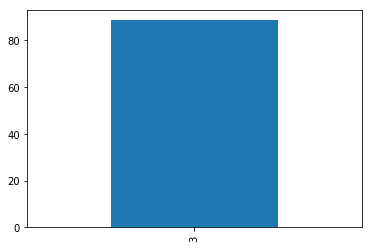

AR2
      n                     wc__oecd  ipcc period       pcnt
0    49   Engineering and Technology     1    AR2   5.487122
1     1                         None     1    AR2   0.111982
2    14  Medical and Health Sciences     1    AR2   1.567749
3    42        Agricultural Sciences     1    AR2   4.703247
4   750             Natural Sciences     1    AR2  83.986562
5    37              Social Sciences     1    AR2   4.143337
0   993   Engineering and Technology     0    AR2  14.809843
1    13                         None     0    AR2   0.193885
2    83  Medical and Health Sciences     0    AR2   1.237882
3   497        Agricultural Sciences     0    AR2   7.412379
4   406              Social Sciences     0    AR2   6.055183
5  4703             Natural Sciences     0    AR2  70.141685
6    10                   Humanities     0    AR2   0.149142


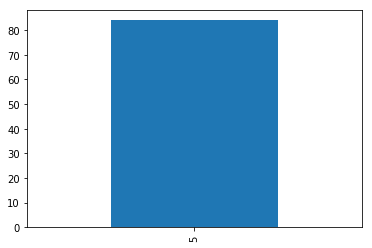

AR3
       n                     wc__oecd  ipcc period       pcnt
0    260   Engineering and Technology     1    AR3   6.123410
1      3                         None     1    AR3   0.070655
2     41  Medical and Health Sciences     1    AR3   0.965615
3    223        Agricultural Sciences     1    AR3   5.252002
4   3512             Natural Sciences     1    AR3  82.713142
5    207              Social Sciences     1    AR3   4.875177
0   2354   Engineering and Technology     0    AR3  13.837291
1     27                         None     0    AR3   0.158711
2    222  Medical and Health Sciences     0    AR3   1.304961
3   1908        Agricultural Sciences     0    AR3  11.215613
4  11776             Natural Sciences     0    AR3  69.221726
5    699              Social Sciences     0    AR3   4.108864
6     26                   Humanities     0    AR3   0.152833


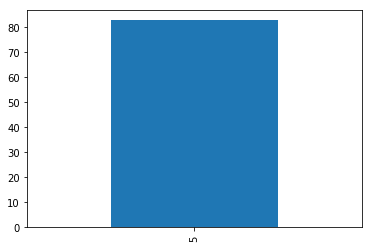

AR4
       n                     wc__oecd  ipcc period       pcnt
0    385   Engineering and Technology     1    AR4   4.969024
1      2                         None     1    AR4   0.025813
2    136  Medical and Health Sciences     1    AR4   1.755292
3    297        Agricultural Sciences     1    AR4   3.833247
4   6266             Natural Sciences     1    AR4  80.872483
5    644              Social Sciences     1    AR4   8.311822
6     18                   Humanities     1    AR4   0.232318
0   5630   Engineering and Technology     0    AR4  13.723674
1     61                         None     0    AR4   0.148693
2    571  Medical and Health Sciences     0    AR4   1.391868
3   4319        Agricultural Sciences     0    AR4  10.527984
4  28277             Natural Sciences     0    AR4  68.927945
5   2073              Social Sciences     0    AR4   5.053140
6     93                   Humanities     0    AR4   0.226697


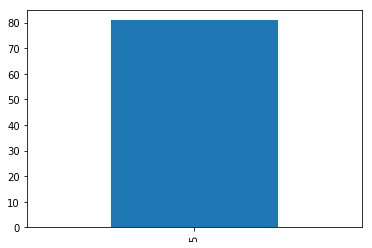

AR5
       n                     wc__oecd  ipcc period       pcnt
0    868   Engineering and Technology     1    AR5   7.854493
1      3                         None     1    AR5   0.027147
2    230  Medical and Health Sciences     1    AR5   2.081260
3    495        Agricultural Sciences     1    AR5   4.479233
4   7990             Natural Sciences     1    AR5  72.301149
5   1449              Social Sciences     1    AR5  13.111936
6     16                   Humanities     1    AR5   0.144783
0  18120   Engineering and Technology     0    AR5  17.342202
1     92                         None     0    AR5   0.088051
2   2438  Medical and Health Sciences     0    AR5   2.333349
3  11468        Agricultural Sciences     0    AR5  10.975738
4  63617             Natural Sciences     0    AR5  60.886252
5   8378              Social Sciences     0    AR5   8.018376
6    372                   Humanities     0    AR5   0.356032


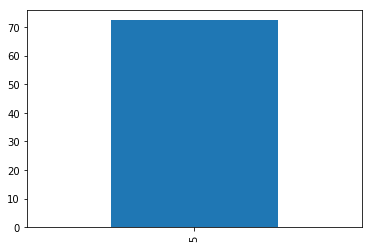

AR6
       n                     wc__oecd  ipcc period       pcnt
0      2   Engineering and Technology     1    AR6   3.703704
1      2        Agricultural Sciences     1    AR6   3.703704
2     38             Natural Sciences     1    AR6  70.370370
3     12              Social Sciences     1    AR6  22.222222
0  19108   Engineering and Technology     0    AR6  14.351163
1  35638                         None     0    AR6  26.766106
2   1760  Medical and Health Sciences     0    AR6   1.321857
3   9481        Agricultural Sciences     0    AR6   7.120755
4  59039             Natural Sciences     0    AR6  44.341550
5   7799              Social Sciences     0    AR6   5.857480
6    321                   Humanities     0    AR6   0.241089


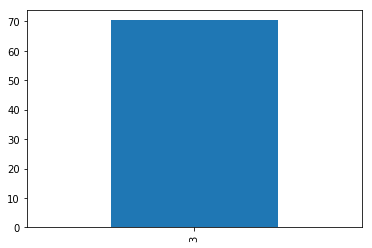

In [86]:
for name, group in df.groupby(['period']):
    print(name)
    print(group)
    group.groupby(['wc__oecd','ipcc'])['pcnt'].plot(kind='bar')
    
    plt.show()

In [ ]:
## OVERREPRESENTATIOn AND UNDER_REPRESENATION OF TOPICS